# Variazioni

Variazioni giornaliere.

> Max Pierini

Dai dati grezzi è stimato il trend tramite decomposizione stagionale con periodo di 7 giorni.

In [1]:
import json
import requests
import datetime as dt

from IPython.display import display, Math, Latex, Image, HTML, Markdown

import matplotlib.pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
import matplotlib.ticker as mtick

from scipy.optimize import curve_fit, brentq
from scipy import stats as sps
from scipy.interpolate import interp1d
from scipy.signal import argrelextrema
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
italy = None
url = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv'
italy = pd.read_csv(
    url,
    usecols=[
        'data', 
        'totale_casi', 'totale_positivi',
        'nuovi_positivi', 'variazione_totale_positivi',
        'deceduti', 'dimessi_guariti',
        'isolamento_domiciliare', 'ricoverati_con_sintomi', 'terapia_intensiva'
    ],
    parse_dates=['data'],
    index_col=['data'],
    ).sort_index()
italy.index = italy.index.normalize()

In [3]:
url = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv'
states = pd.read_csv(url,
    usecols=[
        'data', 'denominazione_regione',
        'totale_casi', 'totale_positivi',
        'nuovi_positivi', 'variazione_totale_positivi',
        'deceduti', 'dimessi_guariti',
        'isolamento_domiciliare', 'ricoverati_con_sintomi', 'terapia_intensiva'
    ],
                     parse_dates=['data'],
                     #index_col=['denominazione_regione', 'data'],
                     ).sort_index()
states['data'] = states.data.dt.normalize()

In [4]:
regions = sorted(states.denominazione_regione.unique())

In [5]:
# find and fix outliers using Hampel filter
# Impl from: https://towardsdatascience.com/outlier-detection-with-hampel-filter-85ddf523c73d

def hampel_filter_pandas(input_series, window_size, n_sigmas=3.0):

    k = 1.4826 # scale factor for Gaussian distribution
    new_series = input_series.copy()

    # helper lambda function 
    MAD = lambda x: np.median(np.abs(x - np.median(x)))
    
    # the use of min_periods is to have rolling window extend towards
    # the end of the data series; in effect, we can apply hampel filter
    # to most recent observations
    # taken from: https://stackoverflow.com/questions/48953313/pandas-rolling-window-boundary-on-start-end-of-series/48953314#48953314
    rolling_window_size = 2*window_size+1
    rolling_median = input_series.rolling(
        window=rolling_window_size,
        min_periods=(rolling_window_size//2),
        center=True).median()
    rolling_mad = k * input_series.rolling(
        window=rolling_window_size,
        min_periods=(rolling_window_size//2),
        center=True).apply(MAD)
    # print(f'rolling_mad = {rolling_mad}, rolling_median = {rolling_median}')
    diff = np.abs(input_series - rolling_median)
    
    where = diff > (n_sigmas * rolling_mad)
    indices = np.argwhere(where.to_numpy()).flatten()
    new_series[indices] = rolling_median[indices]
    
    return new_series, indices

def hampel_filter_dataframe(dataframe, window, sigmas):
    framedict = {'data': dataframe.index}
    outdict = {}
    for col in dataframe.columns:
        filtered, outliers = hampel_filter_pandas(dataframe[col], window, sigmas)
        framedict.update({col: filtered})
        outdict.update({col: outliers})
    newframe = pd.DataFrame(framedict)
    newframe.set_index('data', inplace=True)
    return newframe, outdict

In [6]:
cols = ['nuovi_positivi', 'deceduti', 'variazione_totale_positivi', 'dimessi_guariti']
df_it = pd.DataFrame(
    index=italy.index[1:]
)
for col in cols:
    if col in ['deceduti', 'dimessi_guariti']:
        _df = italy[col].diff()[1:]
    else:
        _df = italy[col][1:]
    sea_pos = seasonal_decompose(_df, period=7)
    df_it[f"{col}_trend"] = sea_pos.trend
    df_it[f"{col}_obs"] = sea_pos.observed

# Assolute

## Italia

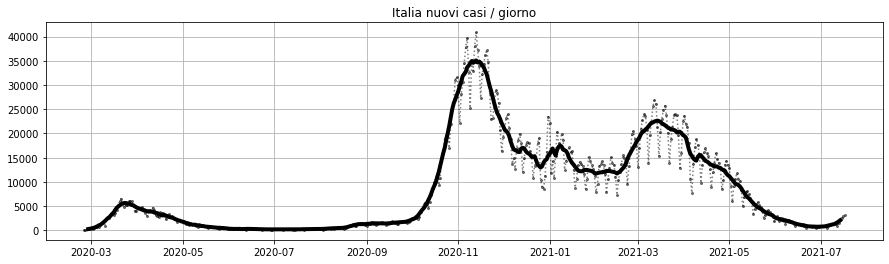

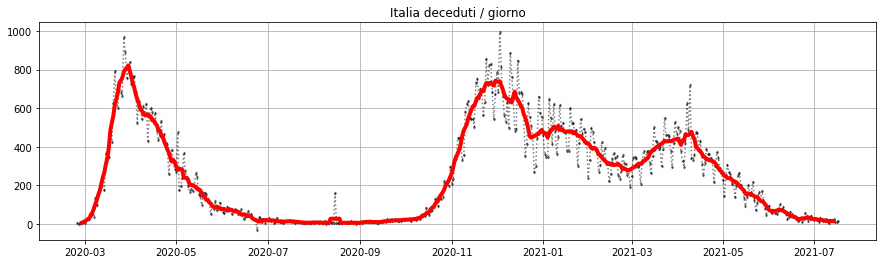

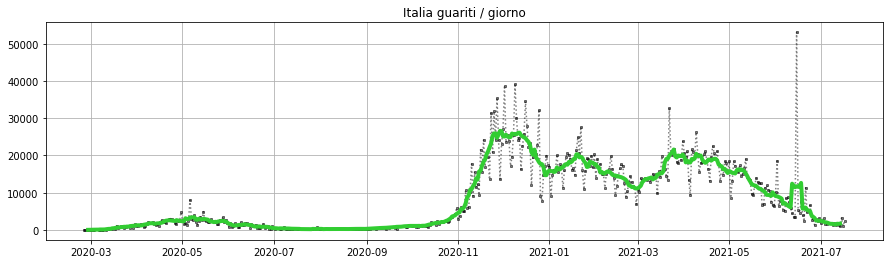

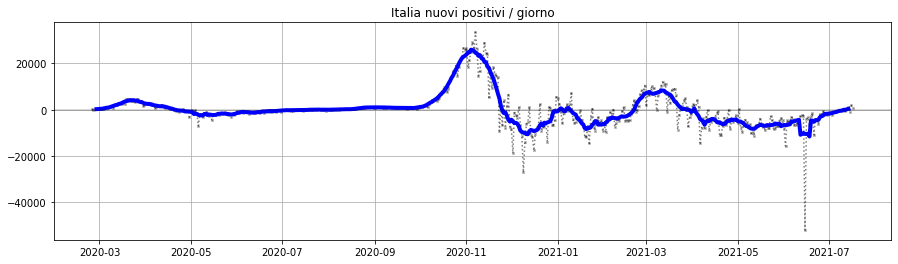

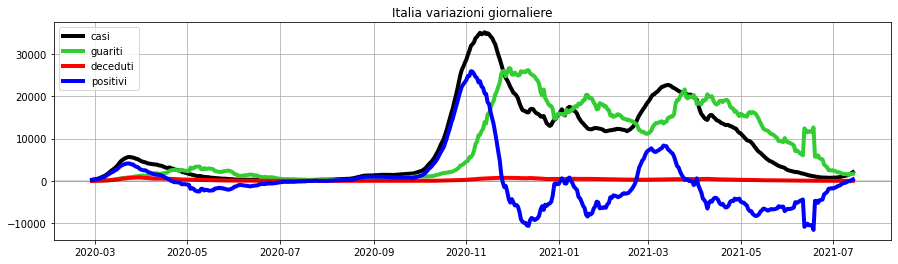

In [7]:
fig, ax = plt.subplots(figsize=(15, 4))

ax.plot(df_it['nuovi_positivi_obs'], 'ok:', alpha=.5, ms=2)
ax.plot(df_it['nuovi_positivi_trend'], 'k', lw=4)
#ax.set_xlim(italy.index[0], italy.index[-1])
#ax.set_ylim(0, italy['nuovi_positivi'].max()*1.1)
ax.set_title("Italia nuovi casi / giorno")
plt.grid(axis='both')
fig.set_facecolor('w'); plt.show();

fig, ax = plt.subplots(figsize=(15, 4))
ax.plot(df_it['deceduti_obs'], 'dk:', alpha=.5, ms=2)
ax.plot(df_it['deceduti_trend'], 'r', lw=4)
#ax.set_xlim(italy.index[0], italy.index[-1])
#ax.set_ylim(0, italy['deceduti'].diff().max()*1.1)
ax.set_title("Italia deceduti / giorno")
plt.grid(axis='both')
fig.set_facecolor('w'); plt.show();

fig, ax = plt.subplots(figsize=(15, 4))
ax.plot(df_it['dimessi_guariti_obs'], 'sk:', alpha=.5, ms=2)
ax.plot(df_it['dimessi_guariti_trend'], 'limegreen', lw=4)
#ax.set_xlim(italy.index[0], italy.index[-1])
#ax.set_ylim(0, italy['dimessi_guariti'].diff().max()*1.1)
ax.set_title("Italia guariti / giorno")
plt.grid(axis='both')
fig.set_facecolor('w'); plt.show();

fig, ax = plt.subplots(figsize=(15, 4))
ax.plot(df_it['variazione_totale_positivi_obs'], 'xk:', alpha=.5, ms=2)
ax.plot(df_it['variazione_totale_positivi_trend'], 'b', lw=4)
#ax.set_xlim(italy.index[0], italy.index[-1])
#ax.set_ylim(italy['variazione_totale_positivi'].min()*1.1, italy['variazione_totale_positivi'].max()*1.1)
ax.axhline(0, c='k', alpha=.2)
ax.set_title("Italia nuovi positivi / giorno")
plt.grid(axis='both')
fig.set_facecolor('w'); plt.show();

fig, ax = plt.subplots(figsize=(15, 4))
ax.plot(df_it['nuovi_positivi_trend'], 'k', lw=4, label='casi')
ax.plot(df_it['dimessi_guariti_trend'], 'limegreen', lw=4, label='guariti')
ax.plot(df_it['deceduti_trend'], 'r', lw=4, label='deceduti')
ax.plot(df_it['variazione_totale_positivi_trend'], 'b', lw=4, label='positivi')
#ax.set_xlim(italy.index[0], italy.index[-1])
#ax.set_ylim(smoothed_italy['totale_positivi'].min()*1.05, smoothed_italy['totale_casi'].max()*1.05)
ax.axhline(0, c='k', alpha=.2)
ax.legend(loc='upper left')
ax.set_title("Italia variazioni giornaliere")
plt.grid(axis='both')
fig.set_facecolor('w'); plt.show();

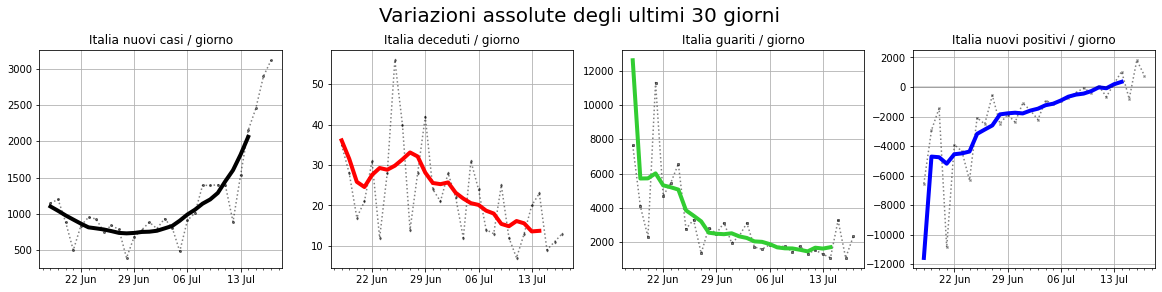

In [8]:
from_day = -30

fig, ax = plt.subplots(1, 4, figsize=(20, 4), sharex=True)

ax[0].plot(df_it['nuovi_positivi_obs'][from_day:], 'ok:', alpha=.5, ms=2)
ax[0].plot(df_it['nuovi_positivi_trend'][from_day:], 'k', lw=4)
#ax[0].set_xlim(italy.index[from_day], italy.index[-1]+pd.Timedelta(days=1))
#ax[0].set_ylim(filtered_italy['totale_casi'][from_day:].min(), filtered_italy['totale_casi'][from_day:].max())
ax[0].set_title("Italia nuovi casi / giorno")
ax[0].grid(axis='both')

ax[1].plot(df_it['deceduti_obs'][from_day:], 'dk:', alpha=.5, ms=2)
ax[1].plot(df_it['deceduti_trend'][from_day:], 'r', lw=4)
#ax[1].set_xlim(italy.index[from_day], italy.index[-1]+pd.Timedelta(days=1))
#ax[1].set_ylim(filtered_italy['deceduti'][from_day:].min(), filtered_italy['deceduti'][from_day:].max())
ax[1].set_title("Italia deceduti / giorno")
ax[1].grid(axis='both')

ax[2].plot(df_it['dimessi_guariti_obs'][from_day:], 'sk:', alpha=.5, ms=2)
ax[2].plot(df_it['dimessi_guariti_trend'][from_day:], 'limegreen', lw=4)
#ax[2].set_xlim(italy.index[from_day], italy.index[-1]+pd.Timedelta(days=1))
#ax[2].set_ylim(filtered_italy['dimessi_guariti'][from_day:].min(), filtered_italy['dimessi_guariti'][from_day:].max())
ax[2].set_title("Italia guariti / giorno")
ax[2].grid(axis='both')

ax[3].plot(df_it['variazione_totale_positivi_obs'][from_day:], 'xk:', alpha=.5, ms=2)
ax[3].plot(df_it['variazione_totale_positivi_trend'][from_day:], 'b', lw=4)
#ax[3].set_xlim(italy.index[from_day], italy.index[-1])
#ax[3].set_ylim(
#    filtered_italy['totale_positivi'][from_day:].min(), 
#    filtered_italy['totale_positivi'][from_day:].max()
#)
ax[3].axhline(0, c='k', alpha=.2)
ax[3].set_title("Italia nuovi positivi / giorno")
ax[3].grid(axis='both')

ax[3].xaxis.set_major_locator(mdates.WeekdayLocator())
ax[3].xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
ax[3].xaxis.set_minor_locator(mdates.DayLocator())

#for i in np.arange(0, 4):
#    ax[i].fill_between(italy.index[-7:], -1e15, 1e15, color='k', alpha=.1)

fig.suptitle(f"Variazioni assolute degli ultimi {-from_day} giorni", fontsize=20, y=1.03)

fig.set_facecolor('w'); plt.show();

## Regioni

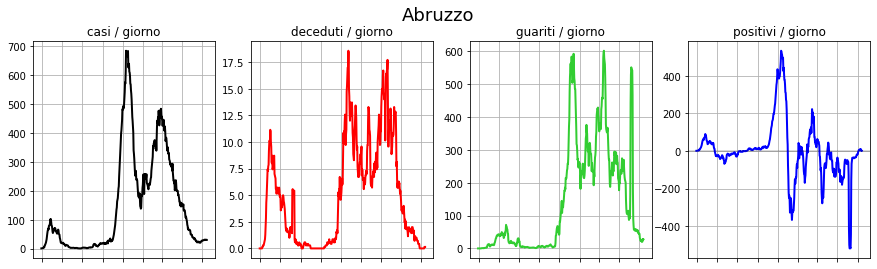

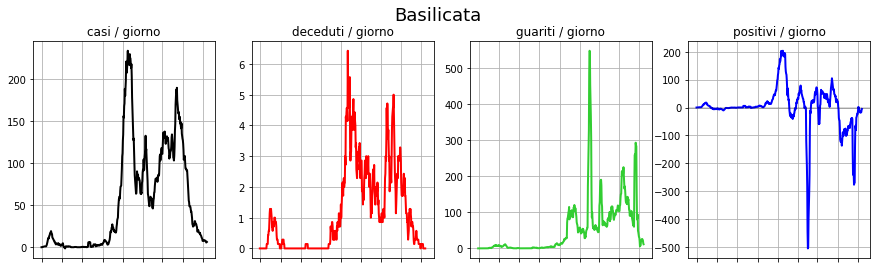

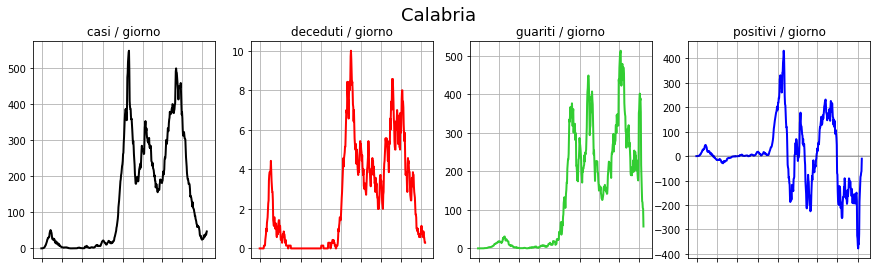

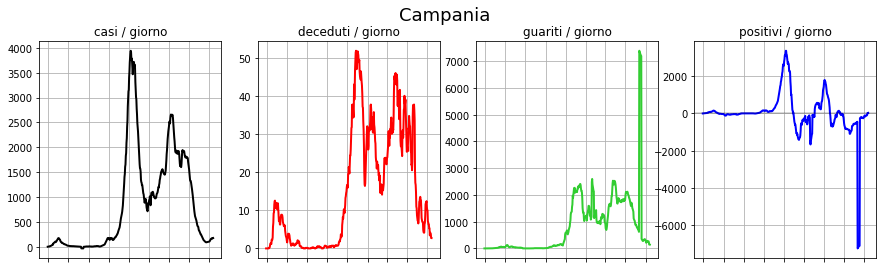

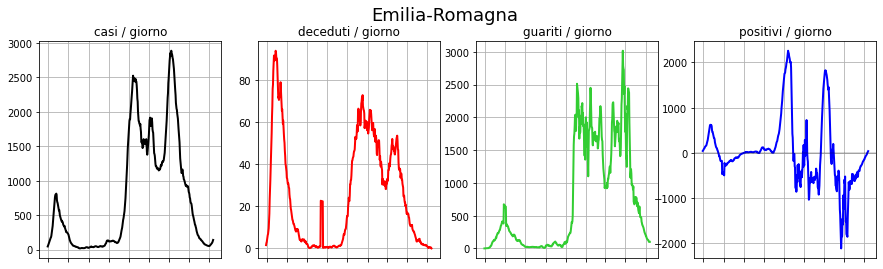

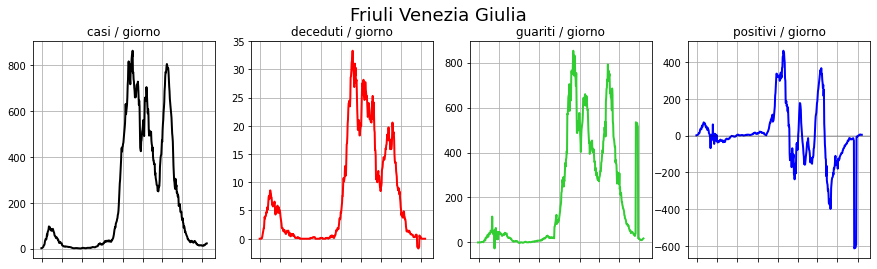

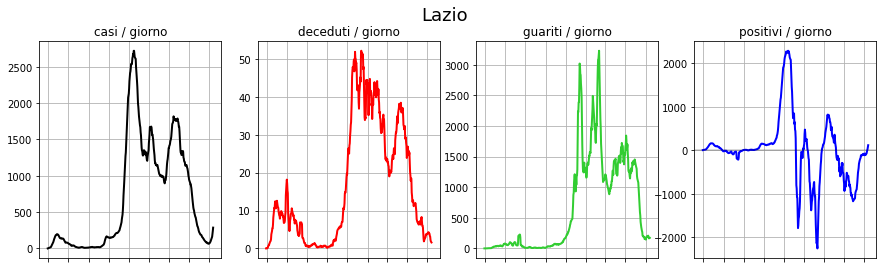

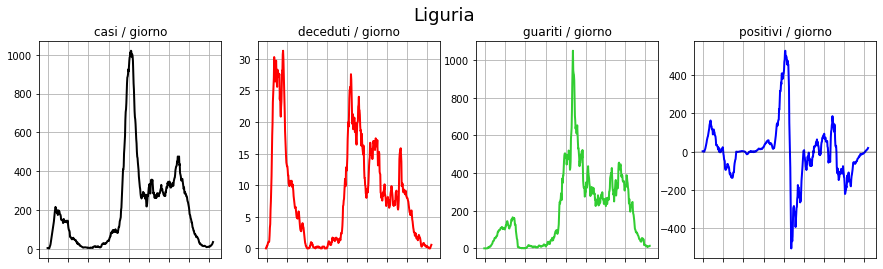

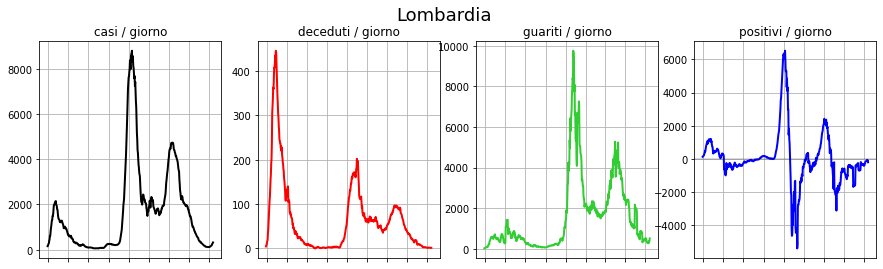

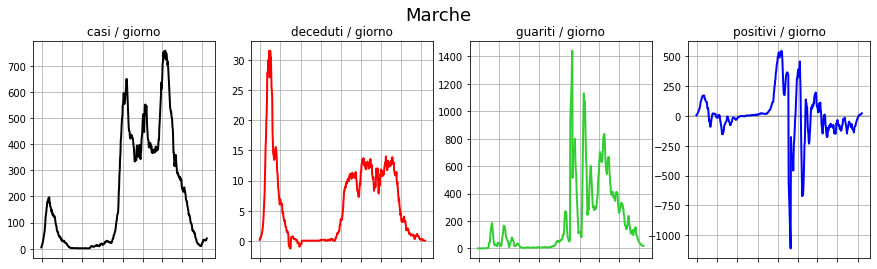

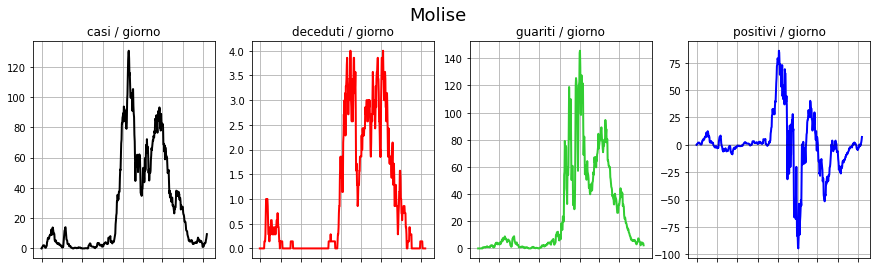

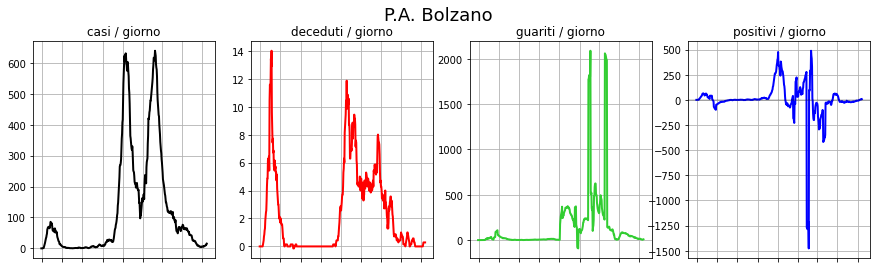

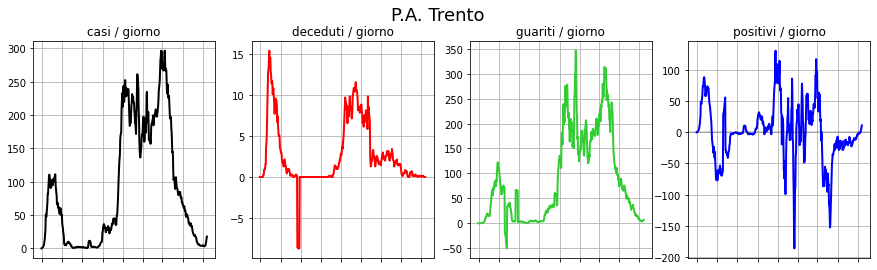

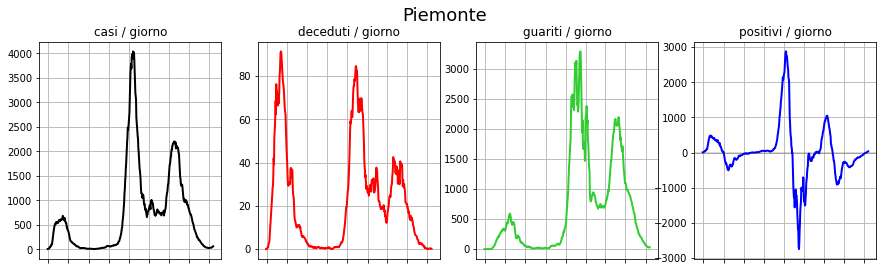

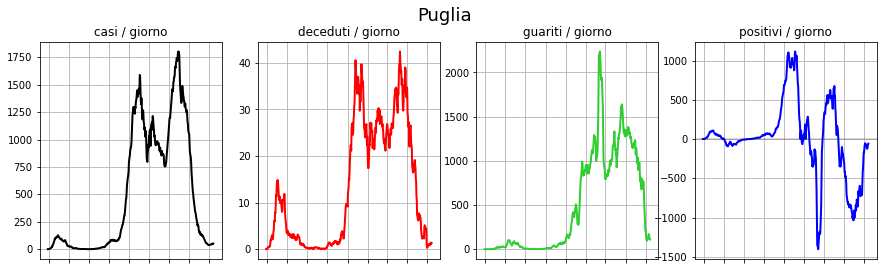

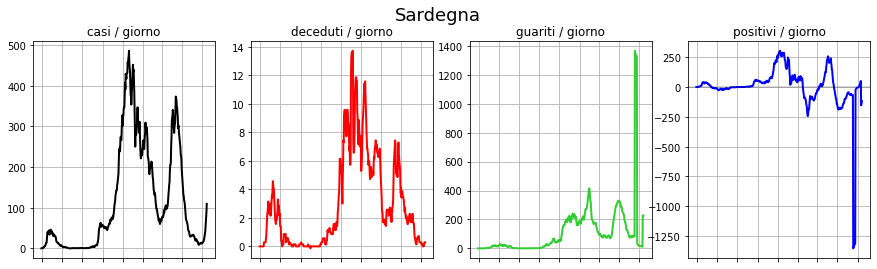

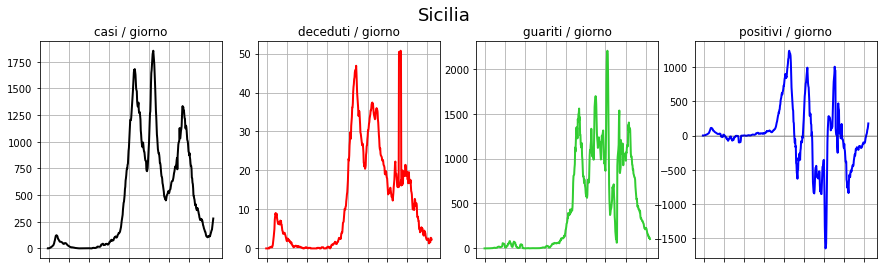

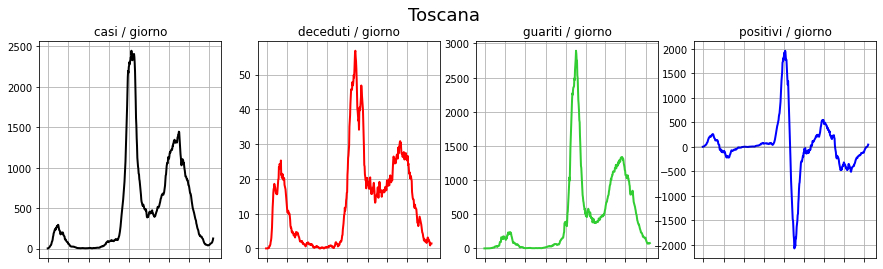

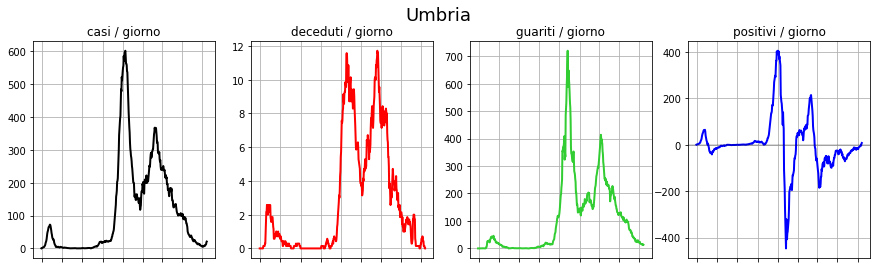

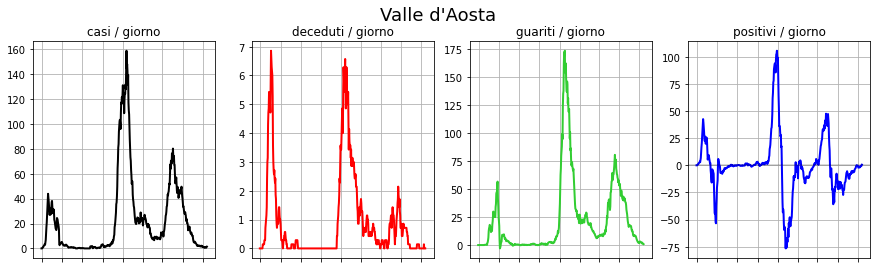

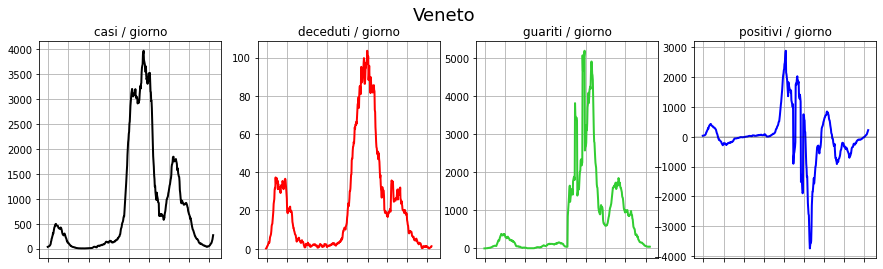

In [9]:
for region in regions:
    _df_rg = states[states.denominazione_regione==region].set_index('data')
    df_rg = pd.DataFrame(
        index=_df_rg.index[1:]
    )
    for col in cols:
        if col in ['deceduti', 'dimessi_guariti']:
            _df = _df_rg[col].diff()[1:]
        else:
            _df = _df_rg[col][1:]
        sea_pos = seasonal_decompose(_df, period=7)
        df_rg[f"{col}_trend"] = sea_pos.trend
        df_rg[f"{col}_obs"] = sea_pos.observed
        
    fig, ax = plt.subplots(1, 4, figsize=(15, 4))
    fig.suptitle(region, y=1, fontsize=18)

    #ax[0].plot(df_rg['totale_casi_'], 'ok:', alpha=.5, ms=2)
    ax[0].plot(df_rg['nuovi_positivi_trend'], 'k', lw=2)
    #ax[0].set_xlim(days[0], days[-1])
    #ax[0].set_ylim(0, smoothed_states['totale_casi'].max()*1.1)
    ax[0].set_title(f"casi / giorno")
    ax[0].set_xticklabels([])
    ax[0].grid(axis='both')

    #ax[1].plot(days, filtered_states['deceduti'], 'dk:', alpha=.5, ms=2)
    ax[1].plot(df_rg['deceduti_trend'], 'r', lw=2)
    #ax[1].set_xlim(days[0], days[-1])
    #ax[1].set_ylim(0, smoothed_states['deceduti'].max()*1.1)
    ax[1].set_title(f"deceduti / giorno")
    ax[1].set_xticklabels([])
    ax[1].grid(axis='both')

    #ax[2].plot(days, filtered_states['dimessi_guariti'], 'sk:', alpha=.5, ms=2)
    ax[2].plot(df_rg['dimessi_guariti_trend'], 'limegreen', lw=2)
    #ax[2].set_xlim(days[0], days[-1])
    #ax[2].set_ylim(0, smoothed_states['dimessi_guariti'].max()*1.1)
    ax[2].set_title(f"guariti / giorno")
    ax[2].set_xticklabels([])
    ax[2].grid(axis='both')

    #ax[3].plot(days, filtered_states['totale_positivi'], 'xk:', alpha=.5, ms=2)
    ax[3].plot(df_rg['variazione_totale_positivi_trend'], 'b', lw=2)
    #ax[3].set_xlim(days[0], days[-1])
    #ax[3].set_ylim(
    #    smoothed_states['totale_positivi'].min()*1.1, 
    #    smoothed_states['totale_positivi'].max()*1.1
    #)
    ax[3].axhline(0, c='k', alpha=.2)
    ax[3].set_title(f"positivi / giorno")
    ax[3].set_xticklabels([])
    ax[3].grid(axis='both')

    fig.set_facecolor('w'); plt.show();

# Percentuali

## Italia

In [10]:
_italy = df_it[df_it.index>='2020-01-01']

In [11]:
id_min = 45

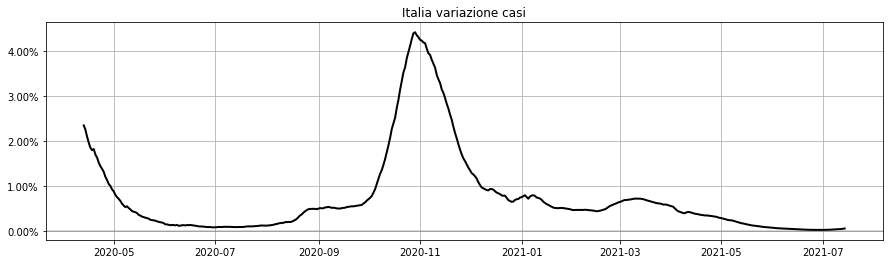

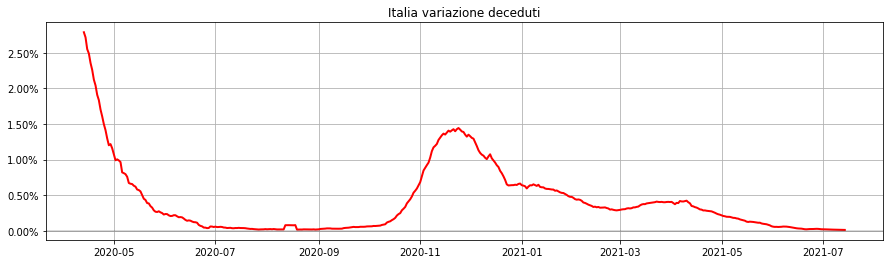

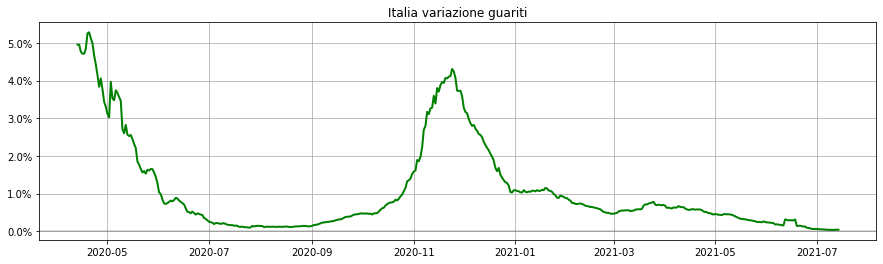

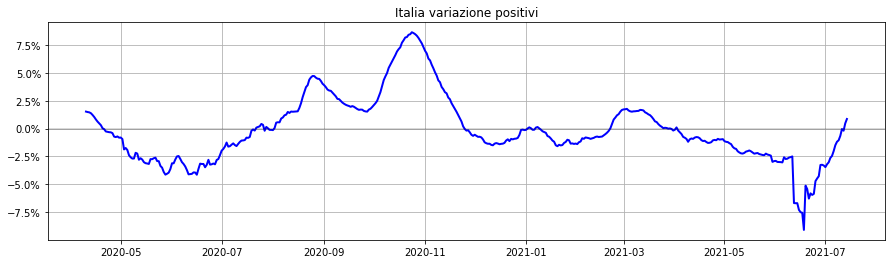

In [12]:
fig, ax = plt.subplots(figsize=(15, 4))
ax.plot(
    _italy['nuovi_positivi_trend'].dropna().cumsum().pct_change().iloc[id_min:],
    'k', ms=3, lw=2
)
#ax.set_xlim(_italy.index[0], _italy.index[-1])
ax.axhline(0, c='k', alpha=.2)
ax.set_title("Italia variazione casi")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.grid(axis='both')
fig.set_facecolor('w'); plt.show();

fig, ax = plt.subplots(figsize=(15, 4))
ax.plot(
    _italy['deceduti_trend'].dropna().cumsum().pct_change().iloc[id_min:],
    'r', ms=3, lw=2
)
#ax.set_xlim(_italy.index[0], _italy.index[-1])
ax.axhline(0, c='k', alpha=.2)
ax.set_title("Italia variazione deceduti")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.grid(axis='both')
fig.set_facecolor('w'); plt.show();

fig, ax = plt.subplots(figsize=(15, 4))
ax.plot(
    _italy['dimessi_guariti_trend'].dropna().cumsum().pct_change().iloc[id_min:],
    'g', ms=3, lw=2
)
#ax.set_xlim(_italy.index[0], _italy.index[-1])
ax.axhline(0, c='k', alpha=.2)
ax.set_title("Italia variazione guariti")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.grid(axis='both')
fig.set_facecolor('w'); plt.show();

sea_pos = seasonal_decompose(italy.totale_positivi.pct_change().dropna(), period=7).trend
fig, ax = plt.subplots(figsize=(15, 4))
ax.plot(
    sea_pos.iloc[id_min:],
    'b', ms=3, lw=2
)
#ax.set_xlim(_italy.index[0], _italy.index[-1])
ax.axhline(0, c='k', alpha=.2)
ax.set_title("Italia variazione positivi")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.grid(axis='both')
fig.set_facecolor('w'); plt.show();

In [13]:
_ = """_states = states[states.index.get_level_values('data')>='2020-04-01']

for region in regions:
    fig, ax = plt.subplots(1, 4, figsize=(15, 4))
    fig.suptitle(region, y=1, fontsize=18)
    
    _region = _states[_states.index.get_level_values('denominazione_regione')==region]
    _days = _region.index.get_level_values('data')
    
    tot, _ = hampel_filter_pandas(_region['totale_casi'].pct_change(), 7, 2)
    dec, _ = hampel_filter_pandas(_region['deceduti'].pct_change(), 7, 2)
    gua, _ = hampel_filter_pandas(_region['dimessi_guariti'].pct_change(), 7, 2)
    pos, _ = hampel_filter_pandas(_region['totale_positivi'].pct_change(), 7, 2)
    
    ax[0].plot(_days, tot, 'sk:', lw=1, ms=3)
    ax[0].set_xlim(days[0], days[-1])
    #ax[0].set_ylim(0, smoothed_states.loc[region]['nuovi_positivi'].max()*1.1)
    ax[0].set_title(f"casi / giorno")
    ax[0].set_xticklabels([])
    ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax[0].grid(axis='both')

    ax[1].plot(_days, dec, 'sr:', lw=1, ms=3)
    ax[1].set_xlim(days[0], days[-1])
    #ax[1].set_ylim(0, smoothed_states.loc[region]['deceduti'].diff().max()*1.1)
    ax[1].set_title(f"deceduti / giorno")
    ax[1].set_xticklabels([])
    ax[1].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax[1].grid(axis='both')

    ax[2].plot(_days, gua, 'sg:', lw=1, ms=3)
    ax[2].set_xlim(days[0], days[-1])
    #ax[2].set_ylim(0, smoothed_states.loc[region]['dimessi_guariti'].diff().max()*1.1)
    ax[2].set_title(f"guariti / giorno")
    ax[2].set_xticklabels([])
    ax[2].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax[2].grid(axis='both')

    ax[3].plot(_days, pos, 'sb:', lw=1, ms=3)
    ax[3].set_xlim(days[0], days[-1])
    #ax[3].set_ylim(smoothed_states.loc[region]['variazione_totale_positivi'].min()*1.1, smoothed_states.loc[region]['variazione_totale_positivi'].max()*1.1)
    ax[3].axhline(0, c='k', alpha=.2)
    ax[3].set_title(f"positivi / giorno")
    ax[3].set_xticklabels([])
    ax[3].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax[3].grid(axis='both')

    fig.set_facecolor('w'); plt.show();"""